# ResNet

Here is ResNet Woot Woot

# Load DataSets

In [1]:
import tensorflow as tf
import hyperopt as hpropt
import numpy as np
import math
import timeit
import random
import pickle
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from util import import_dataset
from multiclass_model import MulticlassModel, lazy_property
from config import ModelConfig, TrainConfig
%matplotlib inline

# Set default to auto import packages
%load_ext autoreload
%autoreload 2

In [2]:
# Form training, developement, and testing data sets
address = r'../../data/smallDataset/'
file_names = {}
file_names['images'] = 'data.npy'
file_names['subs'] = 'subredditlabels'
file_names['dict'] = 'subredditIndex'
file_names['nsfw'] = 'nsfwlabels'
"""
address = r'../../data/fullDataset/'
file_names = {}
file_names['images'] = 'full_data.npy'
file_names['subs'] = 'full_subredditlabels'
file_names['dict'] = 'full_subredditIndex'
file_names['nsfw'] = 'full_nsfwlabels'
"""
data, dictionary = import_dataset(address, file_names)

# Print the sizes as a sanity check
print('Train data shape: ', data.X_train.shape)
print('Train labels shape: ', data.y_train.shape)
print('Validation data shape: ', data.X_val.shape)
print('Validation labels shape: ', data.y_val.shape)
print('Test data shape: ', data.X_test.shape)
print('Test labels shape: ', data.y_test.shape)

('Train data shape: ', (800, 128, 128, 3))
('Train labels shape: ', (800,))
('Validation data shape: ', (100, 128, 128, 3))
('Validation labels shape: ', (100,))
('Test data shape: ', (100, 128, 128, 3))
('Test labels shape: ', (100,))


In [3]:
# Number of different convolutions
NdistinctConvLayers = 4
# Number of layers for each different convolution
Nlayers = [2, 2, 2, 2]
# Number of filters for each different convolution
Nfilters = [64, 128, 256, 512]
# Size of filters
kernelSizes = [3, 3]

model_config = ModelConfig(learning_rate=0.003, eval_batch_size=100)

model_config.RS_NdistinctConvLayers = NdistinctConvLayers
model_config.RS_Nlayers = Nlayers
model_config.RS_Nfilters = Nfilters
model_config.RS_kernelSizes = kernelSizes

In [4]:
class ResNet(MulticlassModel):
    
    def __init__(self, model_config):
        MulticlassModel.__init__(self, model_config)
    
    @lazy_property
    def prediction(self):
        
        conv_init = tf.layers.conv2d(
                    inputs = self.X_placeholder,
                    filters = 64,
                    kernel_size = [7, 7],
                    padding = "same")
    
        block_input = tf.layers.max_pooling2d(
                    inputs = conv_init,
                    pool_size = [2, 2],
                    strides = 2)
    
        for idl in range(self.config.RS_NdistinctConvLayers) :
            if (idl == 0) :
                firstStride = 1
            else :
                firstStride = 2
            
            conv = tf.layers.conv2d(
                        inputs = block_input,
                        filters = self.config.RS_Nfilters[idl],
                        kernel_size = self.config.RS_kernelSizes[0],
                        strides = firstStride,
                        padding = "same")
            convBN = tf.layers.batch_normalization(
                        conv, 
                        training=self.is_training_placeholder)        
            relu = tf.nn.relu(convBN)
            residual = tf.layers.conv2d(
                        inputs = relu,
                        filters = self.config.RS_Nfilters[idl],
                        kernel_size = self.config.RS_kernelSizes[1],
                        strides = 1,
                        padding = "same")
            residualBN = tf.layers.batch_normalization(
                        residual, 
                        training=self.is_training_placeholder)
            block_input = tf.nn.relu(residualBN)
        
            for ilr in range(self.config.RS_Nlayers[idl] - 1) :
            
                conv = tf.layers.conv2d(
                            inputs = block_input,
                            filters = self.config.RS_Nfilters[idl],
                            kernel_size = self.config.RS_kernelSizes[0],
                            strides = 1,
                            padding = "same")
                convBN = tf.layers.batch_normalization(
                            conv, 
                            training=self.is_training_placeholder)        
                relu = tf.nn.relu(convBN)
                residual = tf.layers.conv2d(
                            inputs = relu,
                            filters = self.config.RS_Nfilters[idl],
                            kernel_size = self.config.RS_kernelSizes[1],
                            strides = 1,
                            padding = "same")
                residualBN = tf.layers.batch_normalization(
                            residual, 
                            training=self.is_training_placeholder)        
                output = block_input + residualBN
                outputBN = tf.layers.batch_normalization(
                            output, 
                            training=self.is_training_placeholder)
                block_input = tf.nn.relu(outputBN)
            
        convRes = tf.layers.batch_normalization(
                    block_input, 
                    training=self.is_training_placeholder)
    
        shape = convRes.get_shape().as_list()
        avgPool = tf.nn.avg_pool(
                    value=convRes, 
                    ksize=[1,shape[1],shape[2],1],
                    strides=[1,1,1,1],
                    padding='VALID')
    
        shape = avgPool.get_shape().as_list()
        avgPool_flat = tf.reshape(avgPool,[-1, shape[1]*shape[2]*shape[3]])

        sbrd_logits = tf.layers.dense(inputs=avgPool_flat, units=20)
        nsfw_logits = tf.layers.dense(inputs=avgPool_flat, units=2)

        return sbrd_logits, nsfw_logits

# Train the Model

In [ ]:
# Create model instance
tf.reset_default_graph()

train_config = TrainConfig(num_epochs=2, 
                    train_batch_size=500, 
                    print_every=100, 
                    saver_address=r'ResNet_parameters')
model = ResNet(model_config)

# Create session
session = tf.Session()
model.train(data, session, train_config)

---------------------------------------------------------


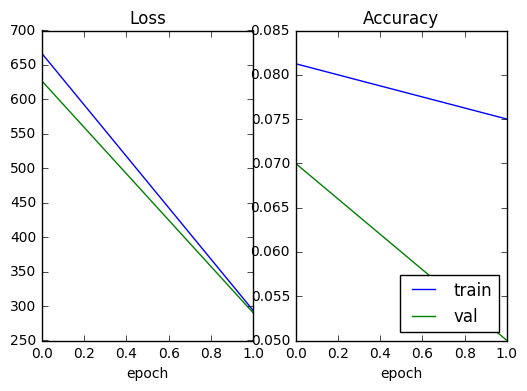

In [29]:
# Plot Loss and Accuracy
model.plot_loss_acc(data)

# Hyperparameter Search

In [10]:
def objective(args):
    
    train_config.num_epochs = args['Nepochs']
    model.config.learning_rate = args['learningRate']
    
    model.train(data, session, train_config)
    cost, accuracy = model.eval(data, session, "val")
    
    saveList = {
        'accuracy' : accuracy,
        'cost' : cost,
        'Nepochs' : args['Nepochs'],
        'learningRate' : args['learningRate'],
        'decayRate' : 5
    }    
    pickle.dump(saveList, open("../../hprOpt/hprPrmOpt_" + str(accuracy) + "_"  + str(cost) + ".dat", "wb"))
    
    return cost

def optimize():
    
    space = {
        'Nepochs' : hpropt.hp.randint('Nepochs', 10),
        'learningRate' : hpropt.hp.loguniform('learningRate', -4, -1)
    }
    
    best = hpropt.fmin(objective, space, algo=hpropt.tpe.suggest, max_evals=10)
    print(best)
    
    return best

In [11]:
optimize()

NameError: global name 'model' is not defined